- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

In [1]:
from tensorflow.keras.layers import Input, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os

In [3]:
from glob import glob
import cv2
from matplotlib.pyplot import imread

In [24]:
DATA_DIR_PATH = './data'
OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '03_out')

In [25]:
os.makedirs(os.path.join(DATA_DIR_PATH, 'datasets'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [26]:
class DataLoader:
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.datasets_path = os.path.join(DATA_DIR_PATH, 'datasets')

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        glob_path = os.path.join(self.datasets_path, self.dataset_name, data_type, '*')
        img_paths = glob(glob_path)

        batch_images = np.random.choice(img_paths, size=batch_size)

        imgs_A = []
        imgs_B = []

        for img_path in batch_images:
            img = self.imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            #img_A = scipy.misc.imresize(img_A, self.img_res)
            img_A = cv2.resize(img_A, self.img_res)
            #img_B = scipy.misc.imresize(img_B, self.img_res)
            img_B = cv2.resize(img_B, self.img_res)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"

        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        glob_path = os.path.join(self.datasets_path, self.dataset_name, data_type, '*')
        img_paths = glob(glob_path)

        self.n_batches = int(len(img_paths) / batch_size)

        #for i in range(self.n_batches-1):
        for i in range(self.n_batches):
            batch = img_paths[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []

            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                #img_A = scipy.misc.imresize(img_A, self.img_res)
                img_A = cv2.resize(img_A, self.img_res)
                #img_B = scipy.misc.imresize(img_B, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, img_path):
        #return scipy.misc.imread(path, mode='RGB').astype(np.float)
        return imread(img_path).astype(np.float)

In [27]:
IMG_ROWS = 256
IMG_COLS = 256

data_loader = DataLoader('facades', img_res=(IMG_ROWS, IMG_COLS))

In [65]:
class Pix2Pix:
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['epoch', 'epochs', 'batch_idx', 'batch_num', 'd_loss', 'acc', 'g_loss', 'elapsed_time'])

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.combined_name = 'combined_model'

        # Input shape
        self.img_rows = IMG_ROWS
        self.img_cols = IMG_COLS
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.data_loader = None
        self.discriminator = None
        self.generator = None
        self.combined = None

    def init(self, data_loader=None):
        # Configure data loader
        #self.dataset_name = 'facades'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))
        if data_loader:
            self.data_loader = data_loader
            self.dataset_name = self.data_loader.dataset_name

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)

        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=-1, save_interval=-1):
        print(datetime.datetime.now().isoformat(), 'Start')

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size), 1):
                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                self.history = self.history.append({
                    'epoch': epoch,
                    'epochs': epochs,
                    'batch_idx': batch_i,
                    'batch_num': self.data_loader.n_batches,
                    'd_loss': d_loss[0],
                    'acc': d_loss[1],
                    'g_loss': g_loss,
                    'elapsed_time': elapsed_time
                }, ignore_index=True)
                print(datetime.datetime.now().isoformat(), '[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s' % (
                    epoch, epochs,
                    batch_i, self.data_loader.n_batches,
                    d_loss[0], 100*d_loss[1],
                    g_loss[0],
                    elapsed_time))

                # If at save interval => save generated image samples
                if sample_interval > 0 and (batch_i % sample_interval) == 0:
                    self.sample_images(epoch, batch_i)

                if save_interval > 0 and batch_i != 1 and (batch_i % save_interval) == 0:
                    file_suffix = '{}_{}'.format(epoch, batch_i)
                    self.save_model_weights(self.combined, self.combined_name, file_suffix)

        print(datetime.datetime.now().isoformat(), 'End')

    def generate_image(self, imgs):
        return self.generator.predict(imgs)

        noise = np.random.normal(0, 1, (1, self.latent_dim))
        labels = np.array([[label]])
        return self.generator.predict([noise, labels])

    def sample_images(self, epoch, batch_i):
        dir_path = os.path.join(self.img_save_dir, self.dataset_name)

        #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        os.makedirs(dir_path, exist_ok=True)

        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i, j].axis('off')
                cnt += 1

        #fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        file_path = os.path.join(dir_path, '%d_%d.png' % (epoch, batch_i))
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_model_weights(self.combined, self.combined_name, file_suffix)

    def save_model_weights(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))
        model.save_weights(file_path)

        print('Model weights saved.', model_name)

    def load_models(self, file_suffix=None):
        self.load_model_weights(self.combined_name, file_suffix)

    def load_model_weights(self, model_name, file_suffix=None):
        model = None

        if model_name == self.combined_name:
            model = self.combined
        else:
            print('Unsupported.', model_name)
            return

        if not model:
            print('Not initialized.', model_name)
            return

        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))

        if not os.path.exists(file_path):
            print('File Not found.', model_name)
            return

        model.load_weights(file_path)

        print('Model weights loaded.', model_name)

    def _create_h5_file_name(self, model_name, suffix=None):
        if suffix:
            return '{}_{}.h5'.format(model_name, suffix)
        else:
            return '{}.h5'.format(model_name)

In [67]:
gan = Pix2Pix()
gan.init(data_loader)

In [68]:
gan.train(epochs=3, batch_size=1, sample_interval=1, save_interval=3)

2020-07-24T23:57:10.657727 Start
2020-07-24T23:57:15.229867 [Epoch 0/3] [Batch 1/3] [D loss: 8.240582, acc:  38%] [G loss: 67.826614] time: 0:00:04.567724
2020-07-24T23:57:17.609015 [Epoch 0/3] [Batch 2/3] [D loss: 4.290652, acc:  43%] [G loss: 73.845497] time: 0:00:06.946870
2020-07-24T23:57:19.998557 [Epoch 0/3] [Batch 3/3] [D loss: 6.802611, acc:  54%] [G loss: 64.898010] time: 0:00:09.336554
Model weights saved. combined_model
2020-07-24T23:57:22.538159 [Epoch 1/3] [Batch 1/3] [D loss: 13.212708, acc:  52%] [G loss: 60.327774] time: 0:00:11.876231
2020-07-24T23:57:24.999100 [Epoch 1/3] [Batch 2/3] [D loss: 8.531518, acc:  53%] [G loss: 46.293221] time: 0:00:14.336202
2020-07-24T23:57:27.602500 [Epoch 1/3] [Batch 3/3] [D loss: 2.782925, acc:  48%] [G loss: 44.605228] time: 0:00:16.939985
Model weights saved. combined_model
2020-07-24T23:57:30.292360 [Epoch 2/3] [Batch 1/3] [D loss: 4.029246, acc:  50%] [G loss: 48.011589] time: 0:00:19.629723
2020-07-24T23:57:32.853038 [Epoch 2/3] [

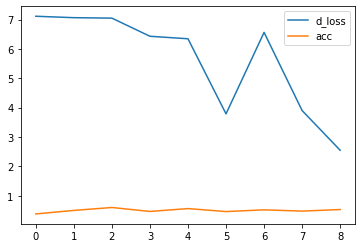

In [31]:
gan.plot_hisotry()

In [32]:
gan.save_models()

Model weights saved. combined_model


In [45]:
gan2 = Pix2Pix()
gan2.init()
gan2.load_models()

Model weights loaded. combined_model


In [50]:
imgs_A, imgs_B = data_loader.load_data(batch_size=1, is_testing=True)
gen_imgs = gan2.generate_image(imgs_B)

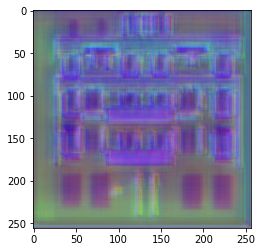

In [51]:
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[0])

In [52]:
from tensorflow.keras.utils import plot_model

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 128, 128, 64) 3136        input_18[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_37 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_37[0][0]             
___________________________________________________________________________________________

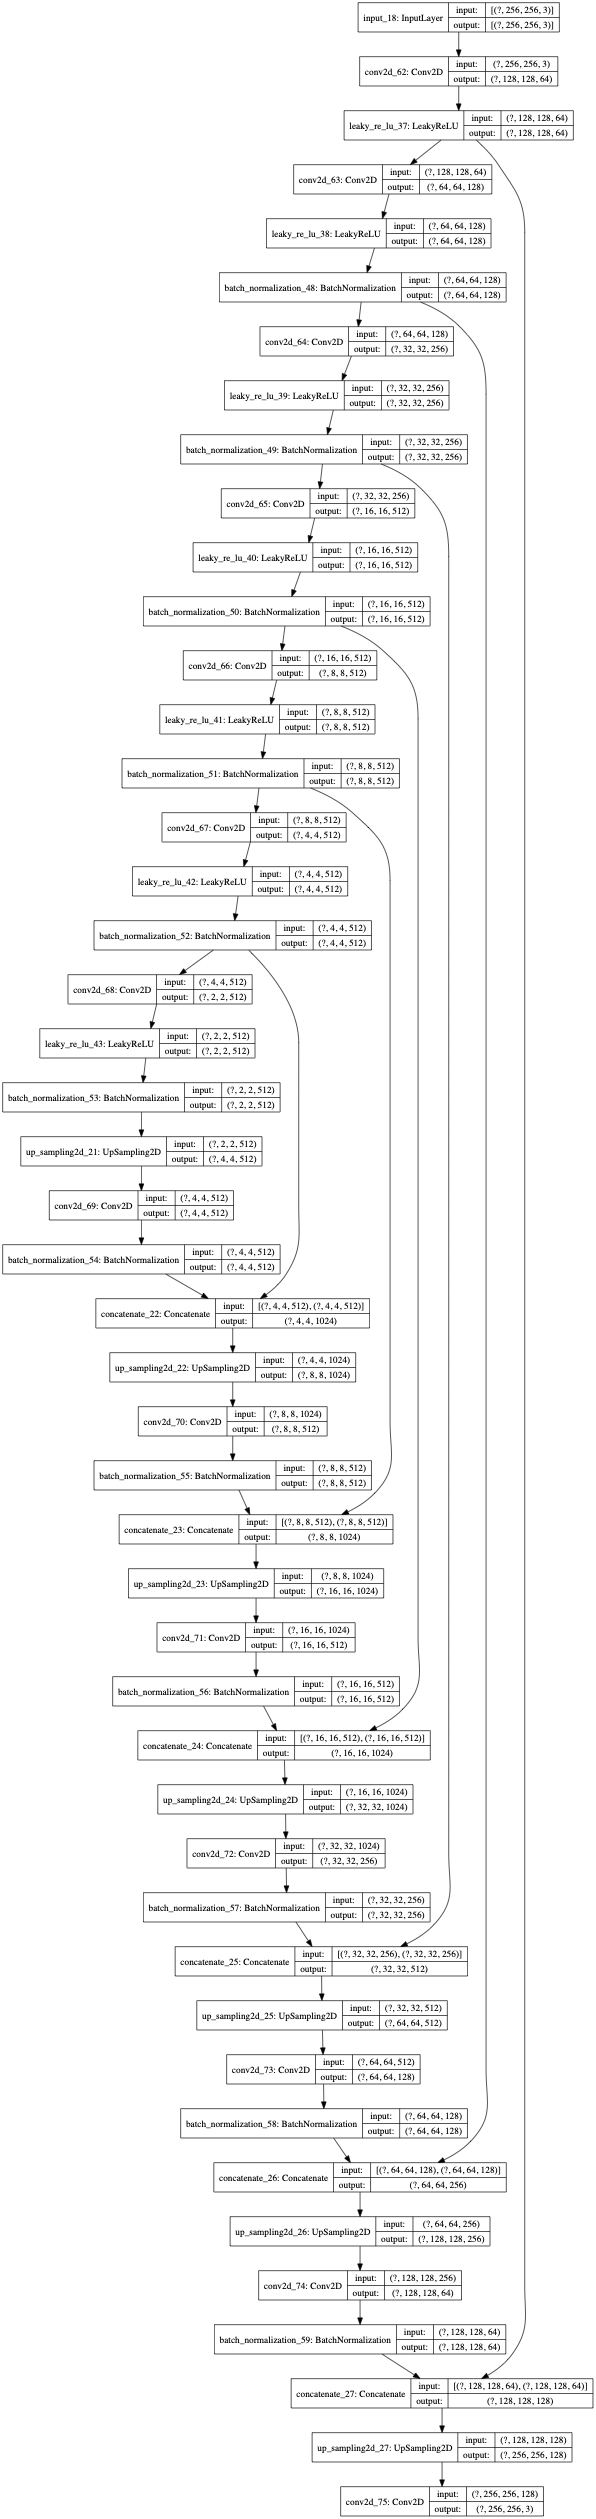

In [53]:
gan.generator.summary()

#plot_model(gan.generator, show_shapes=True, dpi=48)
plot_model(gan.generator, show_shapes=True, dpi=48, expand_nested=True)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 256, 256, 6)  0           input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_21[0][0]       

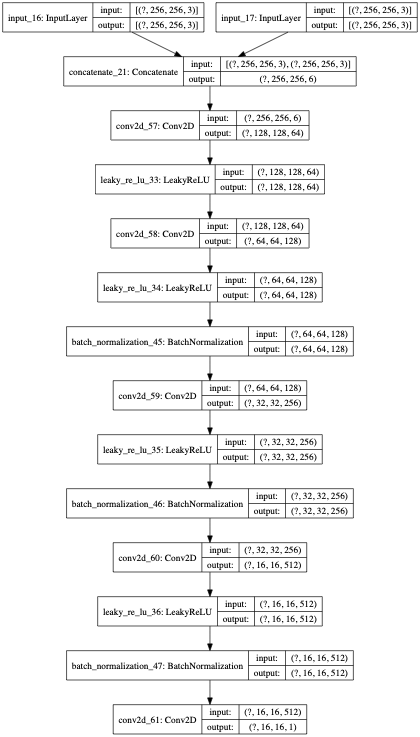

In [56]:
gan.discriminator.summary()

plot_model(gan.discriminator, show_shapes=True, dpi=48, expand_nested=True)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 256, 256, 3)  41843331    input_20[0][0]                   
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 16, 16, 1)    2771393     model_10[1][0]                   
                                                                 input_20[0][0]            

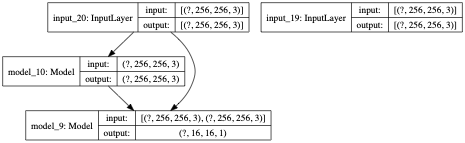

In [64]:
gan.combined.summary()

from tensorflow.keras.layers import Layer

gan.combined._layers = [
  layer for layer in gan.combined._layers if isinstance(layer, Layer)
]
plot_model(gan.combined, show_shapes=True, dpi=48)
#plot_model(gan.combined, show_shapes=True, dpi=48, expand_nested=True)